In [1]:
import sys
sys.path.append('..')

from scripts.data.common import show_sample
from scripts.data.L2ARCTIC import L2ArcticDataset
from scripts.data.TIMIT import TIMITDataset

import torch
from transformers import AutoProcessor, AutoModelForCTC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
clear_output()

In [9]:
# set espeak library path for macOS
import sys
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

# Load Data

In [2]:
arctic = L2ArcticDataset(split='suitcase_corpus', include_speaker_info=True)
timit = TIMITDataset(split='test', include_speaker_info=True)

IPA: jɛsʌmɪtsimzɪffɹʌmðʌfɹsbɪtʃɹzzɪsɪzlaɪkʌbɪktʃɹfʌmʌdaʊntaʊnɔfʌsitiwɪzʌbɪkhɔtɛlʌndtutubipʌlwʌnwʊmʌnændwʌnmænwɛnduzɪshtɛlzʌnbɪkʌzzɛɹɪznsnʌɔnzʌɔnzʌwɛndzɪtʃwʌnlaɪkɹæʒdɪntuɪtʃʌðɹsʌndɑftðætɑftɹkɹæʃʌðeɪfɑnðætsɹbɹaɪzɪŋɡlizɛhævdʌsɛmkɑlɹvzʌbækʌndɪhɪllaɪkɪtsɪssɪmʌlɹbæksækʃʌliʌndɑftkɹæʃɪŋɡɪviwʌndoʊkzɛitʃʌdɹzbækʌndɑftðætwɛnwɛntbæktuðɛɹɹumzðɛfaʊnðætzʌmændoʊkzʌdɛsɔvzʌɑfthɪzbʌnɪŋtszʌzʌbækhɪzbækhifʌnzʌthitɔkʌhifaʊndlaɪkʌɛddɛsɔfʌwʊmʌnʌnzʌwʊmʌnfɑnzʌtʌeɪjɪltʌvðʌmænʌndʌmnɑtʃʊɹwʌtswʌthæbʌnæftθæθ
Metadata: {'gender': 'M', 'native-language': 'Arabic'}


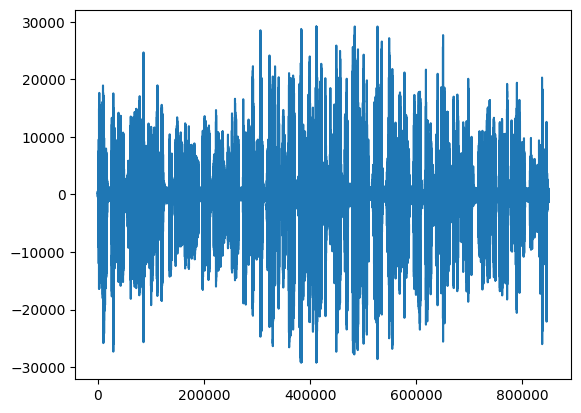

In [3]:
show_sample(arctic[0])

IPA: waɪbaɪʔɔɪəlhwinjuʔoʊwizjuzmaɪn
Metadata: {'SEX': 'M', 'DIALECT': 'North Midland', 'SPLIT': 'TST', 'RECORDING_DATE': '04/15/86', 'BIRTH_DATE': '07/01/61', 'HEIGHT': '6\'1"', 'RACE': ' WHT', 'EDUCATION': 'BS'}


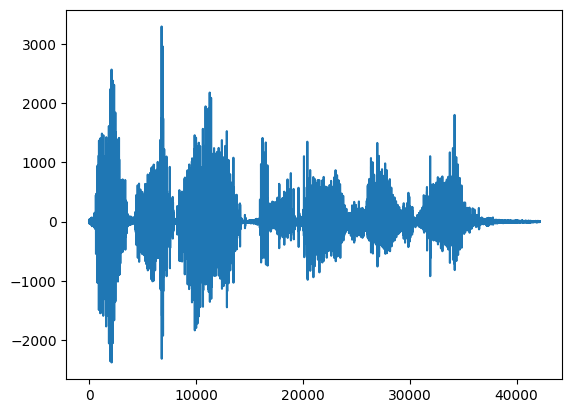

In [4]:
show_sample(timit[1])

# Eval Models

In [5]:
def transcribe_batch(batch, model, processor):
    input_values = processor([x[1] for x in batch], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True).input_values.type(torch.float32).to(model.device)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return [processor.decode(ids) for ids in predicted_ids]

In [6]:
import panphon.distance

def cer(prediction, ground_truth):
    if isinstance(prediction, list):
        prediction = "".join(prediction)
    if isinstance(ground_truth, list):
        ground_truth = "".join(ground_truth)

    if len(ground_truth) == 0:
        return 1.0 if len(prediction) > 0 else 0.0

    matrix = np.zeros((len(prediction) + 1, len(ground_truth) + 1))
    for i in range(len(prediction) + 1):
        matrix[i, 0] = i
    for j in range(len(ground_truth) + 1):
        matrix[0, j] = j

    for i in range(1, len(prediction) + 1):
        for j in range(1, len(ground_truth) + 1):
            if prediction[i - 1] == ground_truth[j - 1]:
                matrix[i, j] = matrix[i - 1, j - 1]
            else:
                substitution = matrix[i - 1, j - 1] + 1
                insertion = matrix[i, j - 1] + 1
                deletion = matrix[i - 1, j] + 1
                matrix[i, j] = min(substitution, insertion, deletion)

    distance = matrix[len(prediction), len(ground_truth)]
    return distance / len(ground_truth)


def preprocess_ipa(ipa_string):
    """Preprocess an IPA string by removing unsupported symbols. Suggestions by David Mortensen, creator of panphon."""
    replacement_map = {
        "ɚ": "ɹ̩",  # Convert /ɚ/ to /ɹ/ (non-syllabic r)
        "ɝ": "ɹ",  # Convert /ɝ/ to /ɹ/ (non-syllabic r)
        "ː": "",  # Remove length mark (or duplicate previous vowel if length is important)
        "͡": "",  # Remove tie bar (or split into components if part of an affricate)
        "g": "ɡ",  # replace two versions of g, TIMIT uses ascii g and STANDARD IPA uses unicode g
    }
    processed_string = "".join(replacement_map.get(char, char) for char in ipa_string)

    return processed_string


def panphon_model_eval(label, predicted):
    label_sequence = preprocess_ipa(label)
    pred_sequence = preprocess_ipa(predicted)

    weighted_feature_dist = panphon.distance.Distance().weighted_feature_edit_distance(
        label_sequence, pred_sequence
    )
    cer_score = cer(predicted, label)

    return cer_score, weighted_feature_dist

In [7]:
scores = pd.DataFrame(columns=['Model', 'Background', 'Gender', 'Dataset', 'Ground Truth', 'Prediction'])
def run_model(model_name, model_id, dataset_metadata_parse_fn, dataset, device='cpu', batch_size=1):
    global scores

    torch.mps.empty_cache()
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForCTC.from_pretrained(model_id).to(device)

    amount = len(dataset)
    for i in range(0, amount, batch_size):
        torch.mps.empty_cache()
        size = min(batch_size, amount - i)
        transcriptions = transcribe_batch(dataset[i:i+size], model, processor)
        for j in range(size):
            background, gender, dataset_name = dataset_metadata_parse_fn(dataset[i+j])
            scores = pd.concat([scores, pd.DataFrame([[
                model_name, 
                background,
                gender, 
                dataset_name,
                dataset[i+j][0],
                transcriptions[j]
            ]], columns=scores.columns)])

In [11]:

for name, model_id in [
    # ("KoelLabs a1", "KoelLabs/xlsr-timit-a1"),
    ("KoelLabs b0", "KoelLabs/xlsr-timit-b0"),
    # ("KoelLabs c0", "KoelLabs/xlsr-timit-c0"),
    # ("KoelLabs d0", "KoelLabs/xlsr-timit-d0"),
    # ("KoelLabs e0", "KoelLabs/xlsr-timit-e0"),
    # ("KoelLabs b1", "KoelLabs/xlsr-timit-b1"),
    # ("KoelLabs c1", "KoelLabs/xlsr-timit-c1"),
    # ("KoelLabs d1", "KoelLabs/xlsr-timit-d1"),
    # ("KoelLabs e1", "KoelLabs/xlsr-timit-e1"),
    ("Taguchi", "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"),
    # ("Rubino", "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"),
    ("Facebook", "facebook/wav2vec2-lv-60-espeak-cv-ft"),
    # ("Vitouphy", "vitouphy/wav2vec2-xls-r-300m-timit-phoneme")
]:
    print(f"Model: {name} ({model_id})")
    print("TIMIT")
    run_model(name, model_id, lambda x: (x[2]['DIALECT'], x[2]['SEX'], 'TIMIT'), timit, 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu', 4)
    print("Arctic")
    run_model(name, model_id, lambda x: (x[2]['native-language'], x[2]['gender'], 'Suitcase'), arctic, 'cpu', 1) 

Model: Facebook (facebook/wav2vec2-lv-60-espeak-cv-ft)
TIMIT
Arctic


In [ ]:
scores[['CER', 'FER']] = scores.apply(lambda x: panphon_model_eval(x['Ground Truth'], x['Prediction']), axis=1, result_type='expand')
clear_output()

In [32]:
scores.head()

Model     Background Gender Dataset  \
0  KoelLabs b0       Southern      F   TIMIT   
0  KoelLabs b0  North Midland      M   TIMIT   
0  KoelLabs b0  South Midland      M   TIMIT   
0  KoelLabs b0  North Midland      M   TIMIT   
0  KoelLabs b0      Army Brat      F   TIMIT   

                       Ground Truth                        Prediction  \
0   dɹɑpfaɪfɔɹmzinəbɑksbifɔjugoʊaʊʔ  ɹɑpθaɪfɔɹmzinðəbɑksbifɔɹjiɡoʊaʊt   
0    waɪbaɪʔɔɪəlhwinjuʔoʊwizjuzmaɪn      hwaɪbaɪʔɔɪlwinjuʔɔwɪzjuzmaɪn   
0                   ʃiɪzθɪɾʊðɪnaɪæm                   ʃiɪzθɪɾʌðinaɪæm   
0  ɹɑbsæpbaɪðəpɑndnskɛtʃtðiʃtɹeɪgis  ɹɑbsɛpaɪðəpɑndnskɛttʃtðiʃtɹeɪɡis   
0    bɑɹbɹndpeɪpɹnlivzinəbɪgbɑnfaɪɹ      ɑɹbɹnpeɪpɹinlivziɾəbɪɡɑnfaɪɹ   

        CER      FER  
0  0.225806  25.8125  
0  0.200000  29.2500  
0  0.133333   0.7500  
0  0.125000  14.8750  
0  0.200000  30.2500

In [22]:
scores.to_csv('../.data/scores.csv', index=False)

# Analyze Results

In [18]:
scores[['Model', 'Dataset', 'CER', 'FER']].groupby(['Model', 'Dataset']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

CER                         FER                  
                          mean       std     n        mean         std     n
Model       Dataset                                                         
Facebook    Suitcase  1.334285  0.105914    22  461.088068  316.909417    22
            TIMIT     1.207842  0.138028  1680   22.549442   12.466454  1680
KoelLabs b0 Suitcase  0.416744  0.076820    22  530.366477  297.455631    22
            TIMIT     0.131464  0.065057  1680   14.729799    9.977333  1680
Taguchi     Suitcase  0.366894  0.077149    22  505.011364  394.935996    22
            TIMIT     0.255646  0.080220  1680   20.792448   11.947160  1680

In [21]:
scores[['Model', 'Dataset', 'Background', 'CER', 'FER']].groupby(['Model', 'Dataset', 'Background']).agg([('mean', np.mean), ('std', np.std), ('n', np.size)]) # type: ignore

CER                        FER  \
                                        mean       std    n        mean   
Model       Dataset  Background                                           
Facebook    Suitcase Arabic         1.315956  0.029835    3  361.750000   
                     Chinese        1.328383  0.124182    4  410.187500   
                     Hindi          1.475634  0.050819    3  475.062500   
                     Korean         1.232722  0.075948    4  802.468750   
                     Spanish        1.377396  0.054483    4  428.765625   
                     Vietnamese     1.306371  0.120080    4  266.953125   
            TIMIT    Army Brat      1.234879  0.140969  110   23.251705   
                     New England    1.217596  0.142374  110   24.240341   
                     New York City  1.198049  0.137492  110   22.670455   
                     North Midland  1.204608  0.128616  260   20.277404   
                     Northern       1.205503  0.137321  260   22.425240   
                     South Midland  1.211268  0.141130  320   23.198438   
                     Southern       1.216351  0.145047  280   23.282366   
                     Western        1.186106  0.130866  230   22.260598   
KoelLabs b0 Suitcase Arabic         0.404356  0.064506    3  496.333333   
                     Chinese        0.411921  0.104660    4  502.656250   
                     Hindi          0.514699  0.023497    3  498.916667   
                     Korean         0.369384  0.068076    4  858.062500   
                     Spanish        0.415477  0.070401    4  494.312500   
                     Vietnamese     0.406020  0.068533    4  315.546875   
            TIMIT    Army Brat      0.129294  0.063552  110   13.724432   
                     New England    0.138476  0.069086  110   15.515909   
                     New York City  0.129541  0.065326  110   14.725568   
                     North Midland  0.118472  0.058388  260   13.496635   
                     Northern       0.120538  0.061286  260   13.788221   
                     South Midland  0.135357  0.068076  320   14.495703   
                     Southern       0.146656  0.067524  280   16.460714   
                     Western        0.133197  0.063486  230   15.513587   
Taguchi     Suitcase Arabic         0.342116  0.074889    3  415.562500   
                     Chinese        0.329757  0.051304    4  398.046875   
                     Hindi          0.441709  0.030269    3  483.833333   
                     Korean         0.348037  0.088987    4  914.671875   
                     Spanish        0.415539  0.091361    4  515.250000   
                     Vietnamese     0.336713  0.074312    4  275.046875   
            TIMIT    Army Brat      0.252762  0.089109  110   19.242614   
                     New England    0.258007  0.083857  110   21.192045   
                     New York City  0.245787  0.078687  110   19.862500   
                     North Midland  0.236696  0.075676  260   18.031971   
                     Northern       0.245535  0.072555  260   20.322115   
                     South Midland  0.273604  0.083033  320   22.543164   
                     Southern       0.272678  0.082460  280   22.285045   
                     Western        0.247742  0.073105  230   21.186685   

                                                     
                                           std    n  
Model       Dataset  Background                      
Facebook    Suitcase Arabic         111.899858    3  
                     Chinese        110.075057    4  
                     Hindi          164.182111    3  
                     Korean         646.652265    4  
                     Spanish        111.273773    4  
                     Vietnamese     116.170654    4  
            TIMIT    Army Brat       11.758249  110  
                     New England     14.729341  110  
                     New York City   12.542873  110  
                 

Observation: All models do significantly better on Vietnamese and significantly worse on Korean

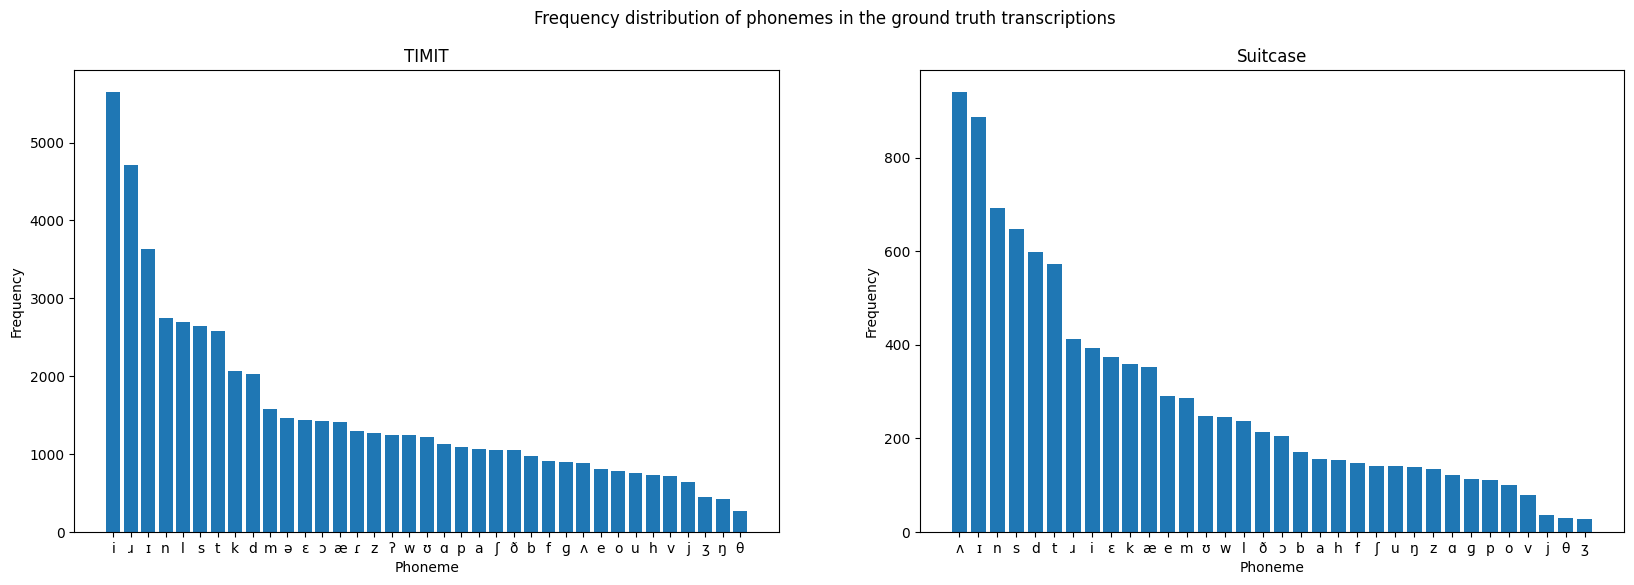

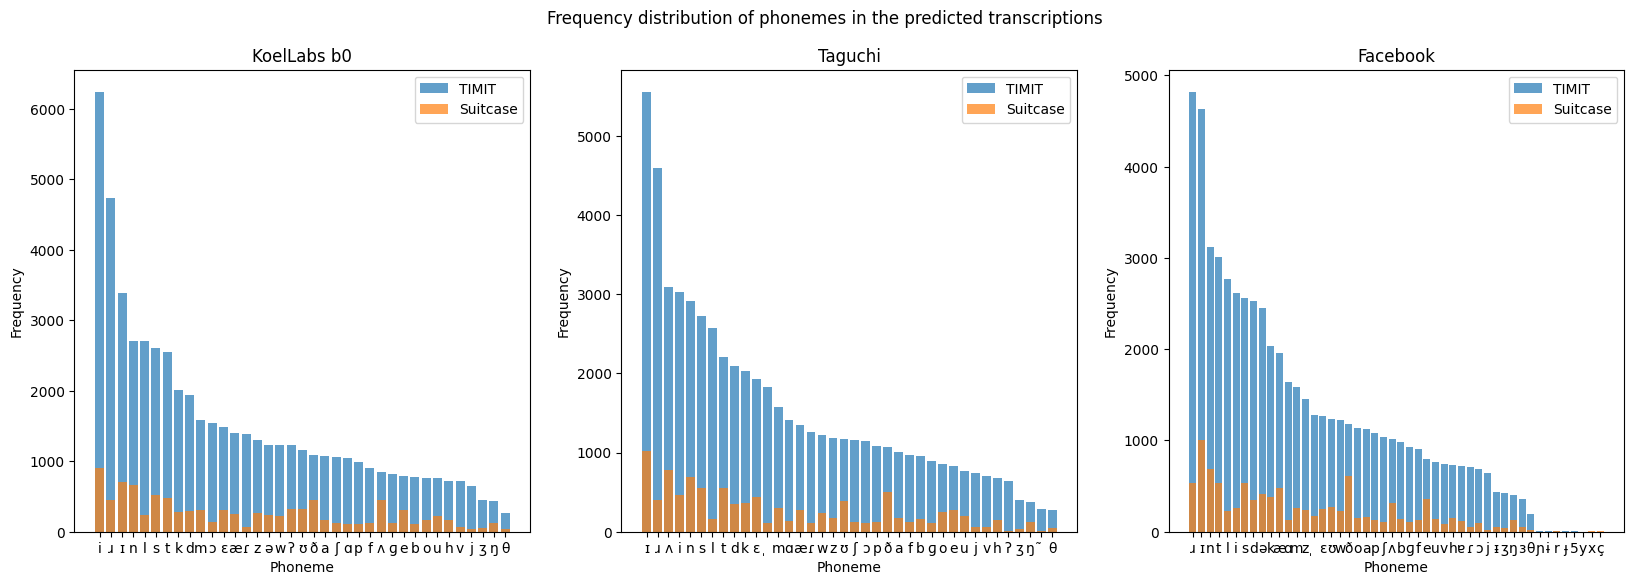

In [108]:
# calculate the frequency distribution of phonemes in the ground truth and predicted transcriptions from scores
from collections import Counter

def phoneme_distribution(scores, column, model, dataset):
    phoneme_counter = Counter()
    for i, row in scores[(scores['Model'] == model) & (scores['Dataset'] == dataset)].iterrows():
        phoneme_counter.update(preprocess_ipa(row[column]).replace(' ', ''))

    return phoneme_counter

phon_dist = pd.DataFrame(columns=['Dataset', 'Phoneme', 'Frequency'])
for dataset in scores['Dataset'].unique():
    phon_dist = pd.concat([phon_dist, pd.DataFrame([
        [dataset, phoneme, freq]
        for phoneme, freq in phoneme_distribution(scores, 'Ground Truth', scores['Model'][0], dataset).items()
    ], columns=phon_dist.columns)])

phon_dist_by_model = pd.DataFrame(columns=['Model', 'Dataset', 'Phoneme', 'Frequency'])
for model in scores['Model'].unique():
    for dataset in scores['Dataset'].unique():
        phon_dist_by_model = pd.concat([phon_dist_by_model, pd.DataFrame([
            [model, dataset, phoneme, freq]
            for phoneme, freq in phoneme_distribution(scores, 'Prediction', model, dataset).items()
        ], columns=phon_dist_by_model.columns)])

# plot the frequency distribution of phonemes in the ground truth
plt.figure(figsize=(20, 6))
plt.suptitle('Frequency distribution of phonemes in the ground truth transcriptions')
for i, dataset in enumerate(phon_dist['Dataset'].unique()):
    plt.subplot(1, 2, i + 1)
    data = phon_dist[phon_dist['Dataset'] == dataset]
    data = data.sort_values('Frequency', ascending=False)
    plt.bar(data['Phoneme'], data['Frequency'])
    plt.title(dataset)
    plt.xlabel('Phoneme')
    plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(20, 6))
plt.suptitle('Frequency distribution of phonemes in the predicted transcriptions')
for i, model in enumerate(phon_dist_by_model['Model'].unique()):
    plt.subplot(1, 3, i + 1)
    for dataset in phon_dist_by_model['Dataset'].unique():
        data = phon_dist_by_model[(phon_dist_by_model['Model'] == model) & (phon_dist_by_model['Dataset'] == dataset)]
        data = data.sort_values('Frequency', ascending=False)
        plt.bar(data['Phoneme'], data['Frequency'], label=dataset, alpha=0.7)
    plt.title(model)
    plt.xlabel('Phoneme')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()

Observation: the Koel Labs model was trained on the TIMIT train set and learned the phoneme distribution of the TIMIT test set. Phoneme level resampling might be necessary for models to generalize to unseen data.

In [166]:
from fastdtw import fastdtw

def fastdtw_phoneme_alignment(seq1, seq2):
    seq1_vectors = list(range(len(seq1)))
    seq2_vectors = list(range(len(seq2)))
    
    distance, path = fastdtw(seq1_vectors, seq2_vectors, dist=lambda x, y: 0 if seq1[int(x)] == seq2[int(y)] else 1)
    
    aligned_seq1 = []
    aligned_seq2 = []
    for i, j in path:
        aligned_seq1.append(seq1[i] if i < len(seq1) else '-')
        aligned_seq2.append(seq2[j] if j < len(seq2) else '-')
    
    return ''.join(aligned_seq1), ''.join(aligned_seq2)

In [167]:
scores.reset_index(drop=True, inplace=True)
scores = scores.loc[:, ~scores.columns.str.contains('->')] # drop all columns with -> in the name
for i, row in scores.iterrows():
    missed_phoneme_pairs = {}
    norm_label, norm_pred = preprocess_ipa(row['Ground Truth']), preprocess_ipa(row['Prediction'])
    norm_label, norm_pred = norm_label.replace(' ', ''), norm_pred.replace(' ', '')
    for pair in zip(*fastdtw_phoneme_alignment(norm_label, norm_pred)):
        if pair[0] != pair[1]:
            missed_phoneme_pairs[pair] = missed_phoneme_pairs.get(pair, 0) + 1
    # add each phoneme pair as a column to the scores dataframe
    for pair, count in missed_phoneme_pairs.items():
        col = f'{pair[0]}->{pair[1]}'
        if col not in scores.columns:
            scores[col] = 0
        col_index = scores.columns.get_loc(col)
        scores.iat[i, col_index] = count
clear_output()

In [168]:
scores.head()

Model     Background Gender Dataset  \
0  KoelLabs b0       Southern      F   TIMIT   
1  KoelLabs b0  North Midland      M   TIMIT   
2  KoelLabs b0  South Midland      M   TIMIT   
3  KoelLabs b0  North Midland      M   TIMIT   
4  KoelLabs b0      Army Brat      F   TIMIT   

                       Ground Truth                        Prediction  \
0   dɹɑpfaɪfɔɹmzinəbɑksbifɔjugoʊaʊʔ  ɹɑpθaɪfɔɹmzinðəbɑksbifɔɹjiɡoʊaʊt   
1    waɪbaɪʔɔɪəlhwinjuʔoʊwizjuzmaɪn      hwaɪbaɪʔɔɪlwinjuʔɔwɪzjuzmaɪn   
2                   ʃiɪzθɪɾʊðɪnaɪæm                   ʃiɪzθɪɾʌðinaɪæm   
3  ɹɑbsæpbaɪðəpɑndnskɛtʃtðiʃtɹeɪgis  ɹɑbsɛpaɪðəpɑndnskɛttʃtðiʃtɹeɪɡis   
4    bɑɹbɹndpeɪpɹnlivzinəbɪgbɑnfaɪɹ      ɑɹbɹnpeɪpɹinlivziɾəbɪɡɑnfaɪɹ   

        CER      FER  d->ɹ  f->θ  ...  e->ŋ  a->ɐ  ŋ->ɜ  θ->k  ð->p  ð->ʒ  \
0  0.225806  25.8125     1     1  ...     0     0     0     0     0     0   
1  0.200000  29.2500     0     0  ...     0     0     0     0     0     0   
2  0.133333   0.7500     0     0  ...     0     0     0     0     0     0   
3  0.125000  14.8750     0     0  ...     0     0     0     0     0     0   
4  0.200000  30.2500     0     0  ...     0     0     0     0     0     0   

   s->ɐ  p->ɔ  v->ɐ  θ->ᵻ  
0     0     0     0     0  
1     0     0     0     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     0     0  

[5 rows x 1432 columns]

In [172]:
# normalize counts based on ground truth phoneme frequencies
phoneme_pairs = [col for col in scores.columns if '->' in col]

scores_norm = scores.copy()
for col in phoneme_pairs:
    phoneme_pair = col.split('->')
    ground_truth_phoneme, _ = phoneme_pair
    ground_truth_phoneme_freq = phon_dist[phon_dist['Phoneme'] == ground_truth_phoneme]
    for dataset in scores['Dataset'].unique():
        dataset_phoneme_freq = ground_truth_phoneme_freq[ground_truth_phoneme_freq['Dataset'] == dataset]
        scores_norm[col] = scores[col].apply(lambda x: x / dataset_phoneme_freq['Frequency'].sum() if dataset_phoneme_freq['Frequency'].sum() > 0 else 0)

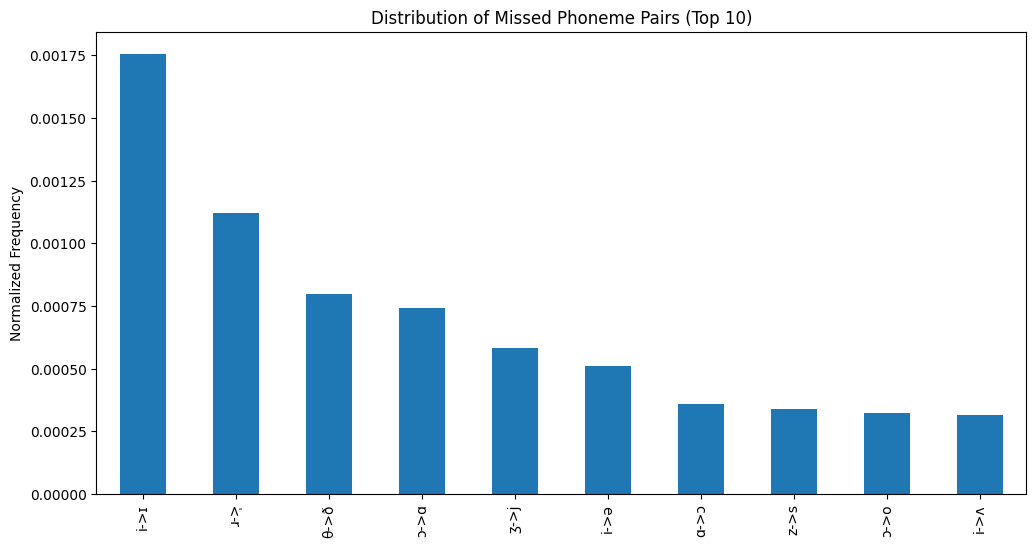

In [173]:
# plot the distribution of phoneme pairs as a bar chart
pair_counts = scores_norm[phoneme_pairs].mean()
pair_counts.sort_values(ascending=False, inplace=True)

# only show the top 10 phoneme pairs
plt.figure(figsize=(12, 6))
pair_counts.head(10).plot(kind='bar')
plt.title('Distribution of Missed Phoneme Pairs (Top 10)')
plt.ylabel('Normalized Frequency')
plt.show()

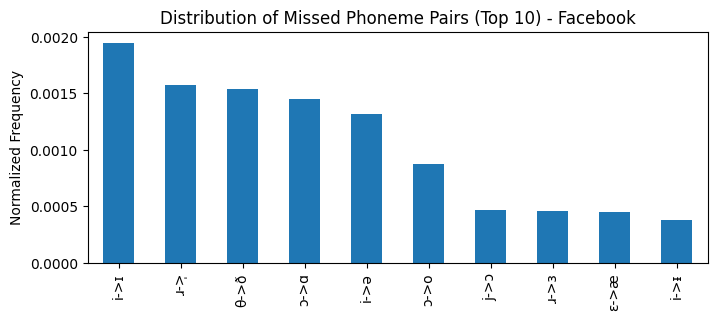

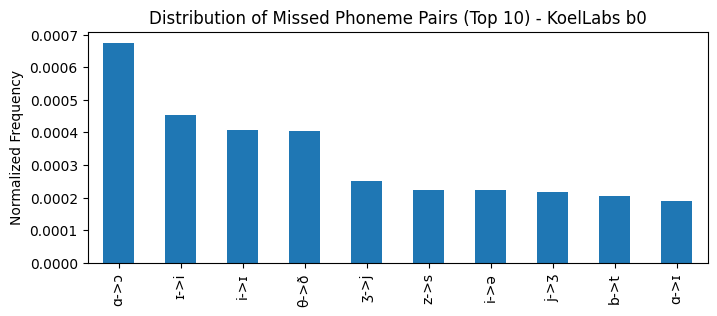

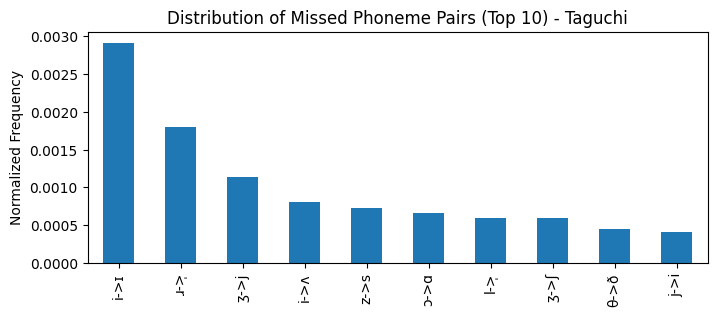

In [174]:
# plot the distribution of phoneme pairs as a bar chart stratified by model
for model, model_scores in scores_norm.groupby('Model'):
    plt.figure(figsize=(8, 3))
    pair_counts = model_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(model))
    plt.ylabel('Normalized Frequency')
    plt.show()

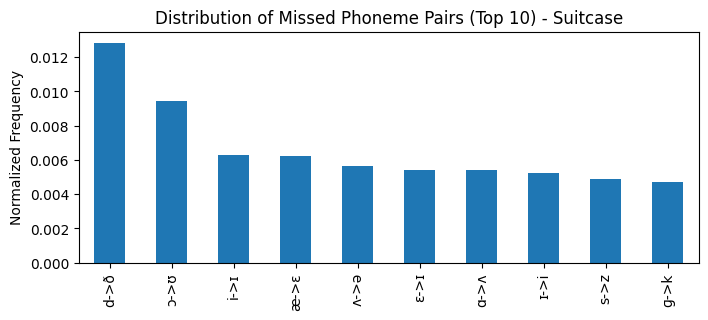

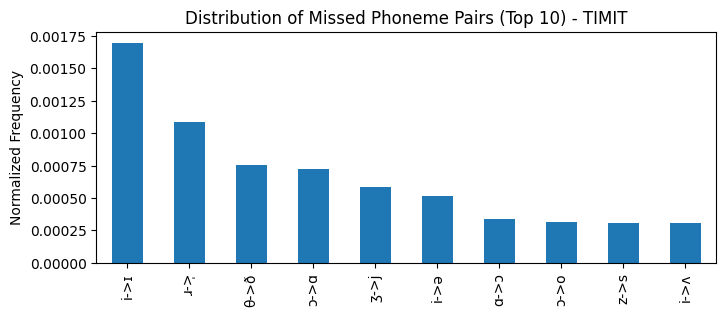

In [175]:
# plot the distribution of phoneme pairs as a bar chart stratified by dataset
for dataset, dataset_scores in scores_norm.groupby('Dataset'):
    plt.figure(figsize=(8, 3))
    pair_counts = dataset_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(dataset))
    plt.ylabel('Normalized Frequency')
    plt.show()

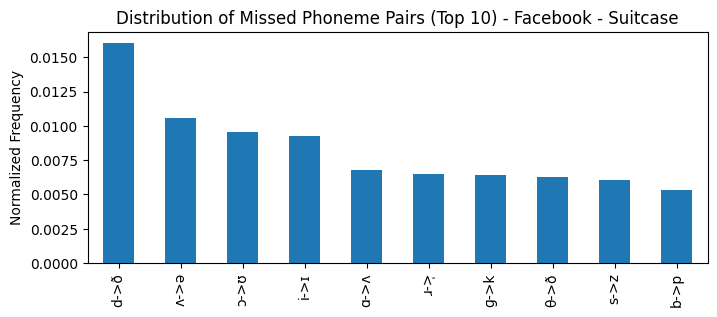

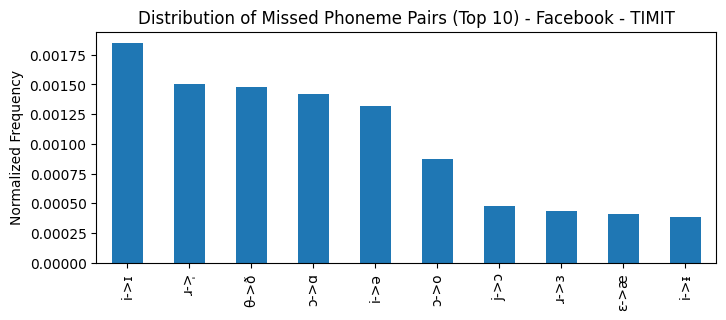

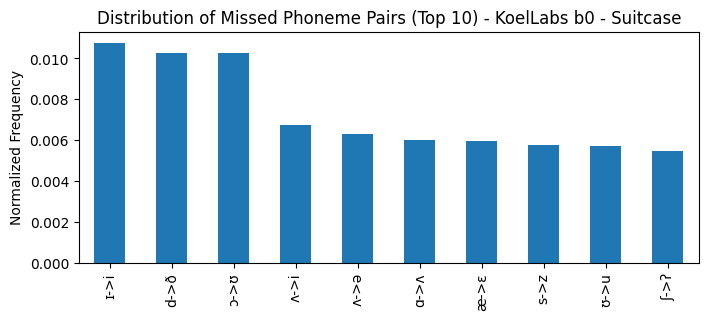

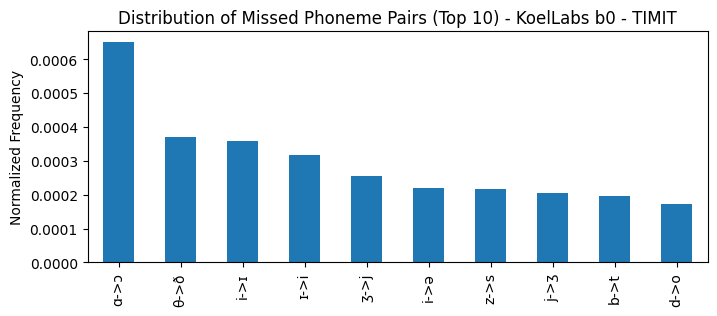

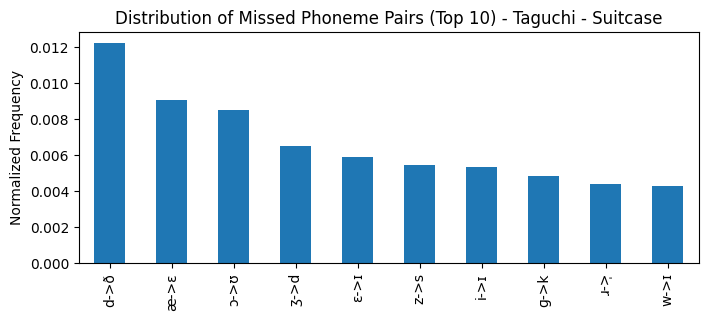

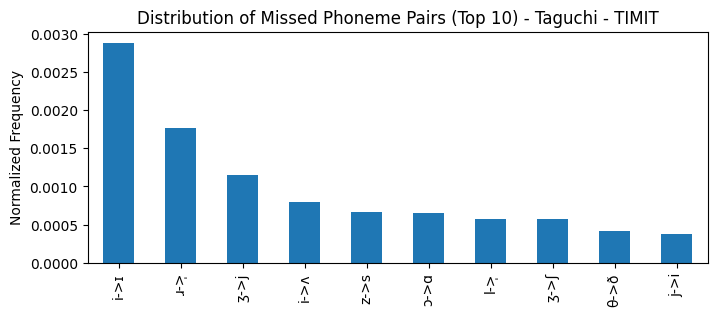

In [176]:
# plot the distribution of phoneme pairs as a bar chart stratified by dataset and model
for (model, dataset), model_dataset_scores in scores_norm.groupby(['Model', 'Dataset']):
    plt.figure(figsize=(8, 3))
    pair_counts = model_dataset_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(model) + ' - ' + str(dataset))
    plt.ylabel('Normalized Frequency')
    plt.show()

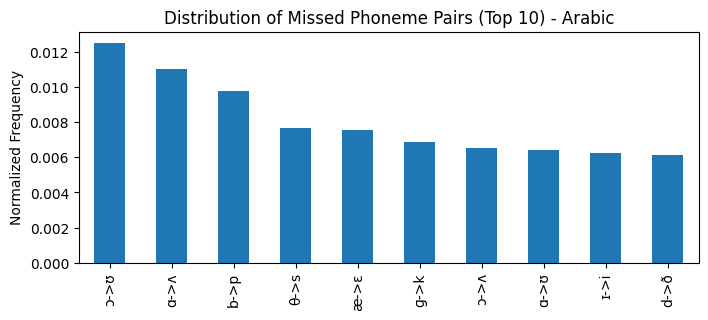

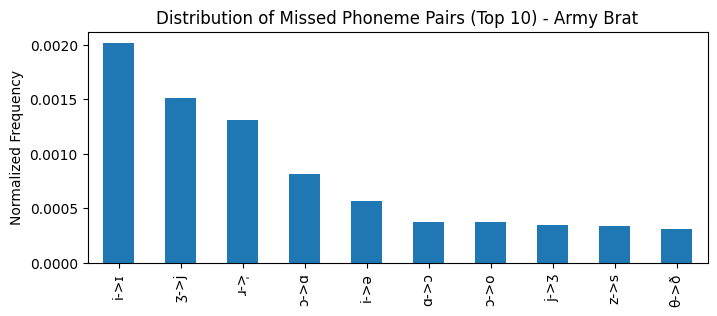

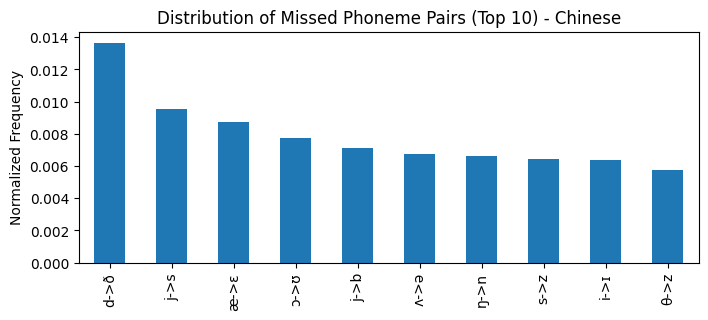

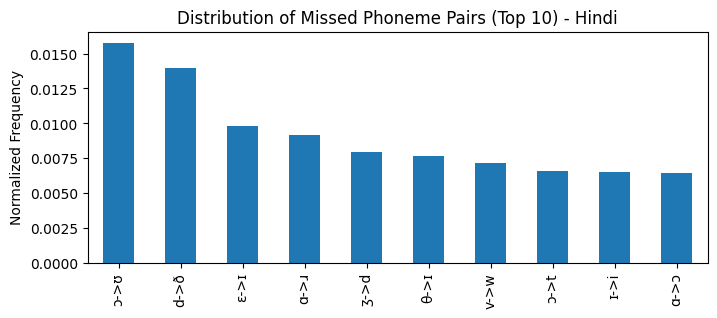

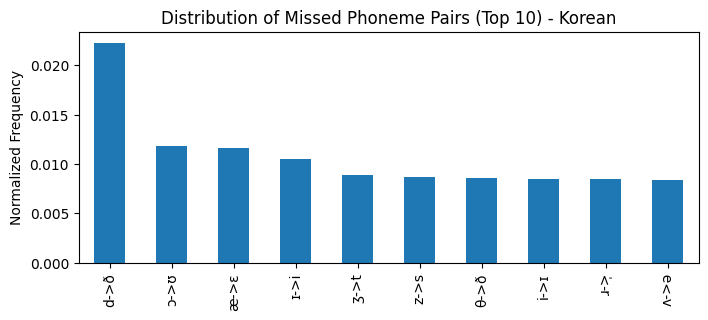

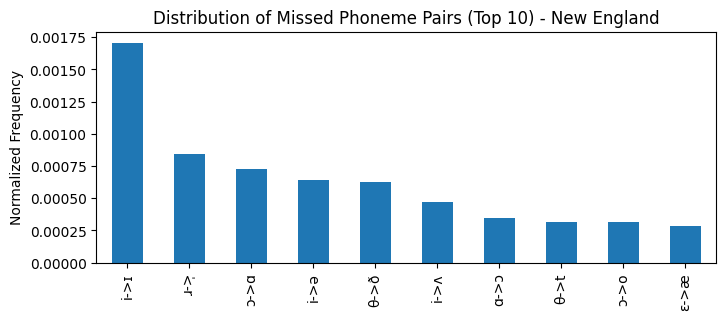

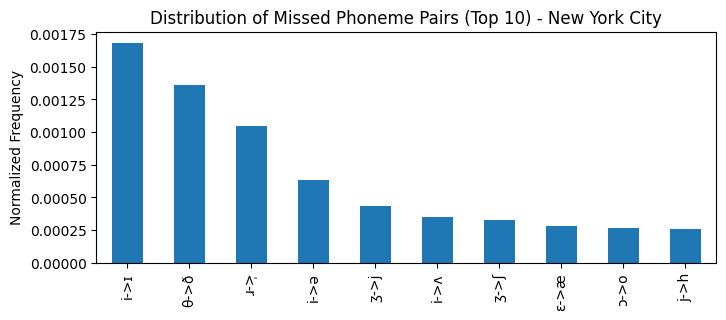

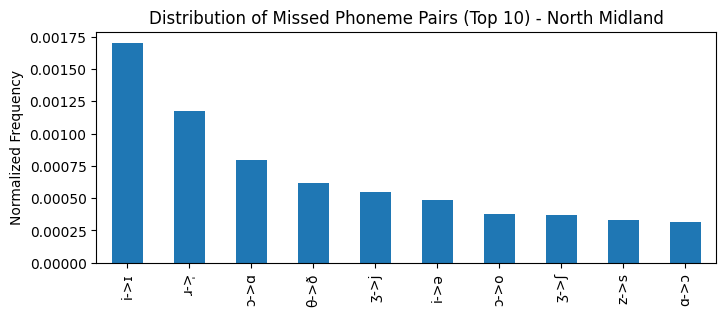

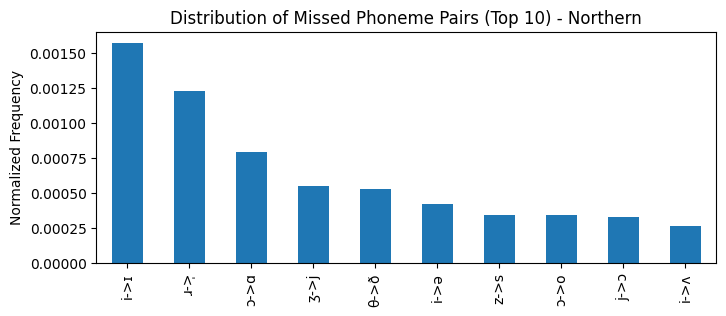

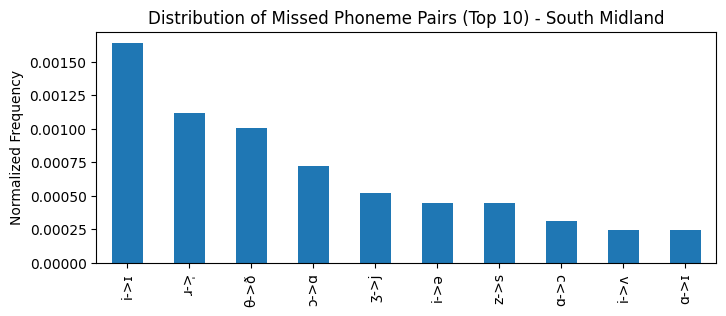

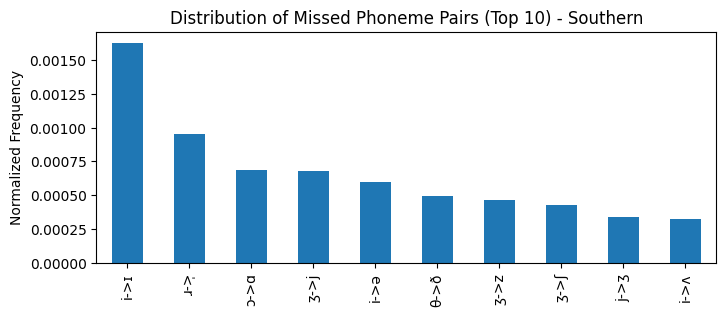

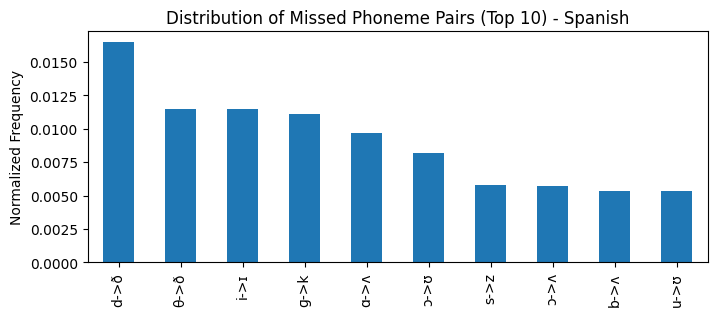

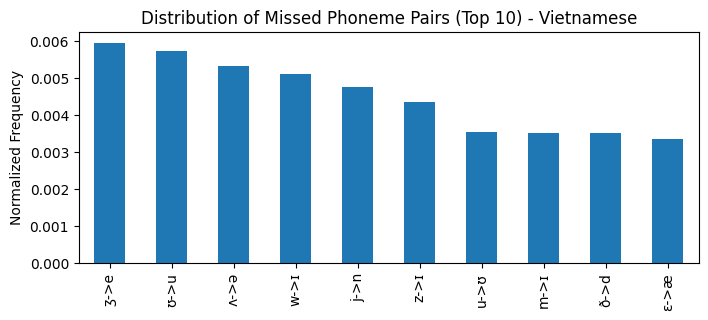

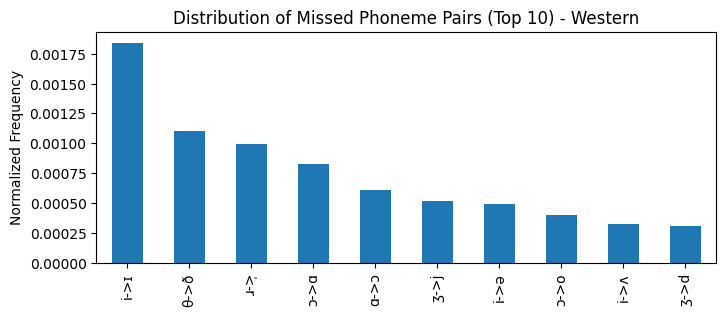

In [177]:
# plot the distribution of phoneme pairs as a bar chart stratified by background
for background, background_scores in scores_norm.groupby('Background'):
    plt.figure(figsize=(8, 3))
    pair_counts = background_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(background))
    plt.ylabel('Normalized Frequency')
    plt.show()

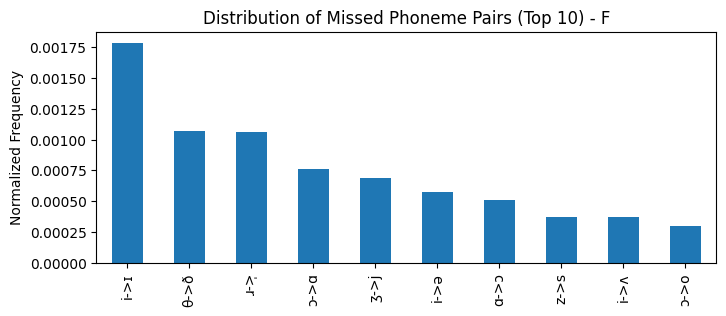

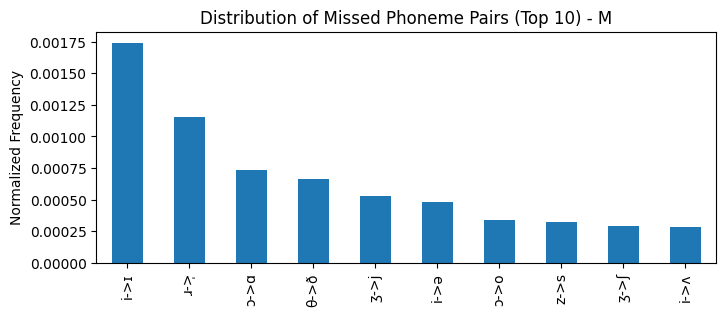

In [178]:
# plot the distribution of phoneme pairs as a bar chart stratified by gender
for gender, gender_scores in scores_norm.groupby('Gender'):
    plt.figure(figsize=(8, 3))
    pair_counts = gender_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(gender))
    plt.ylabel('Normalized Frequency')
    plt.show()

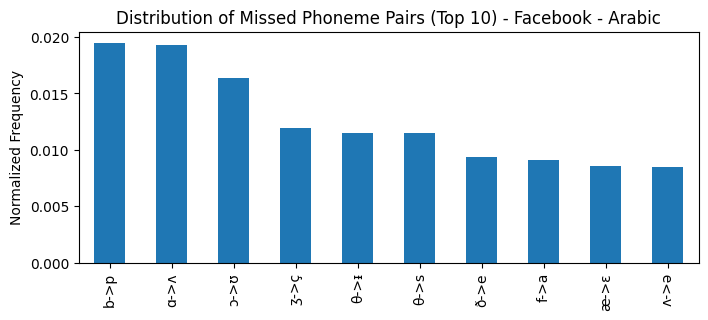

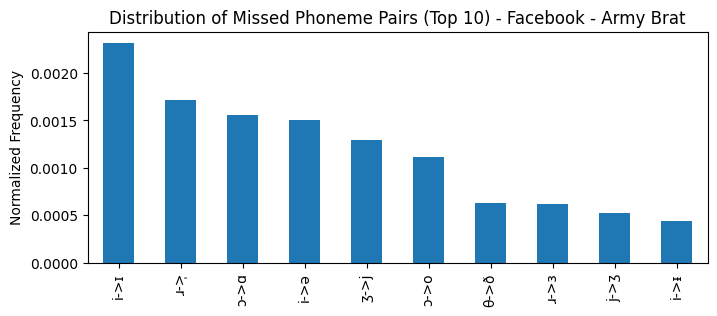

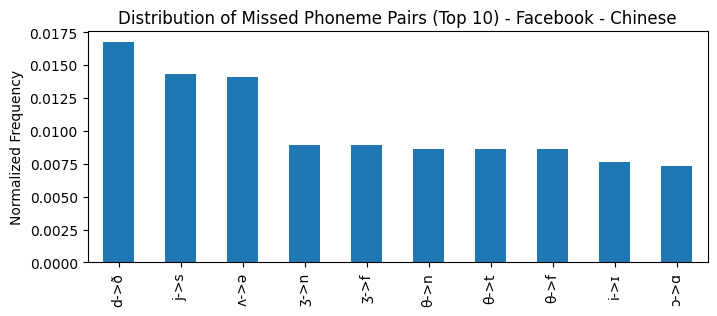

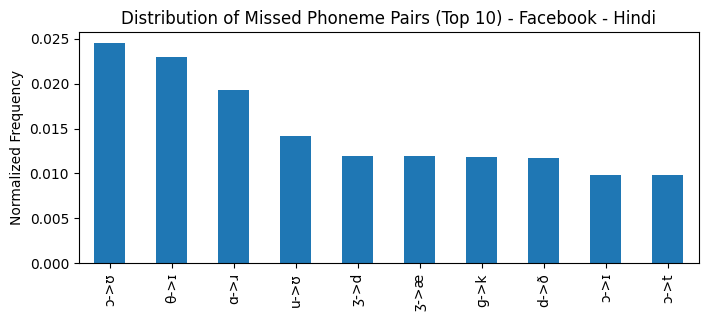

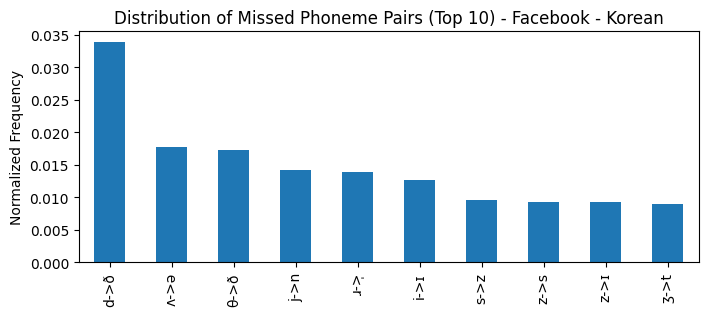

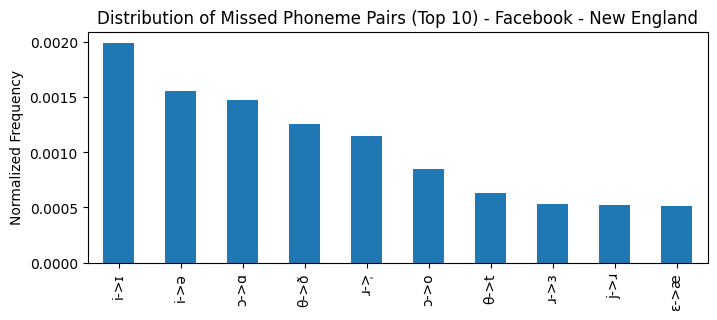

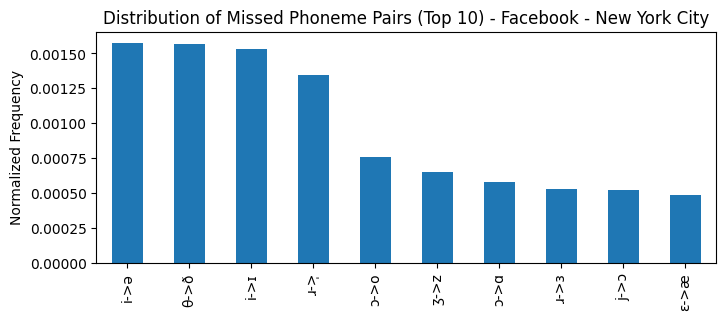

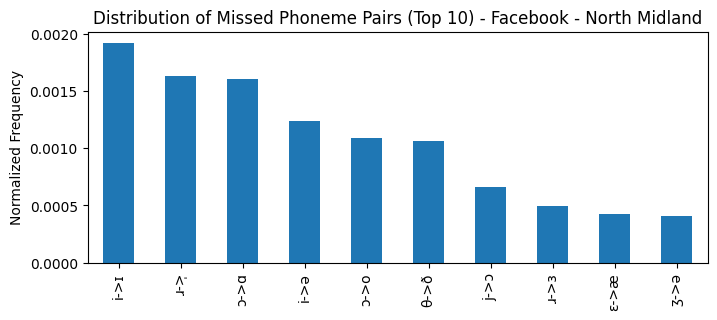

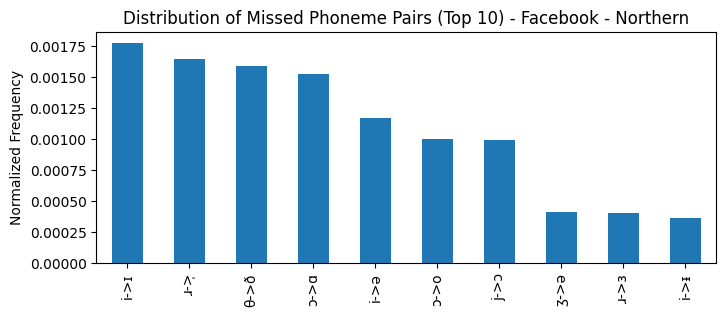

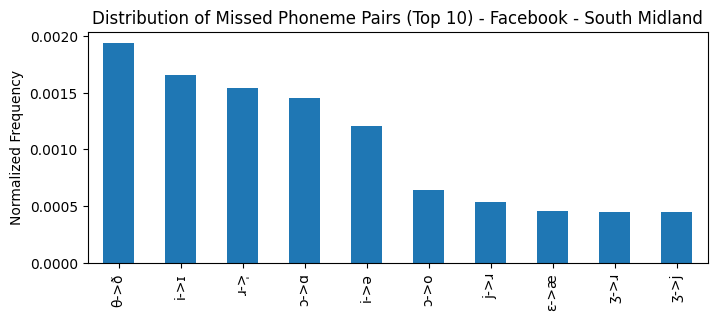

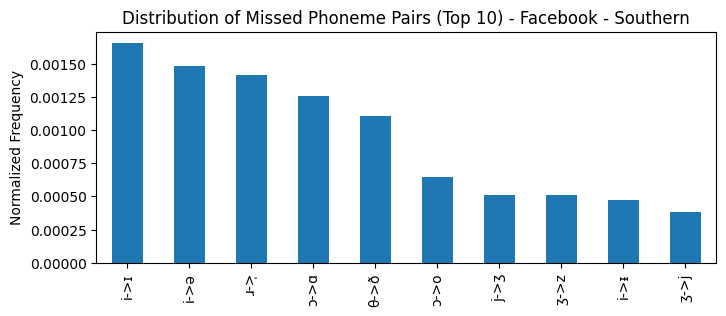

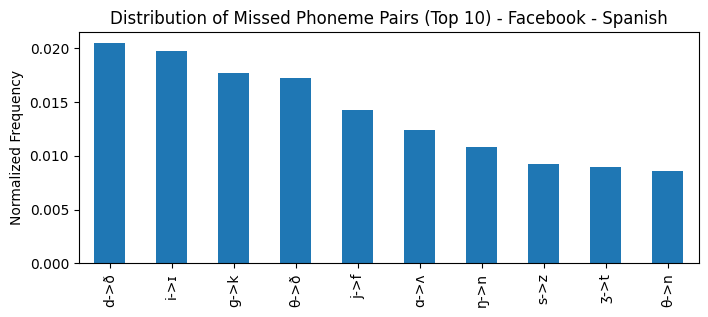

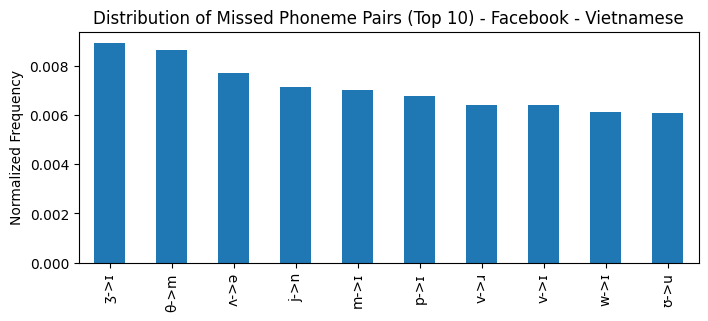

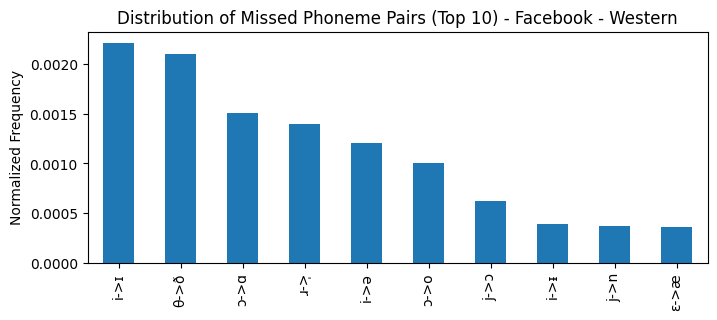

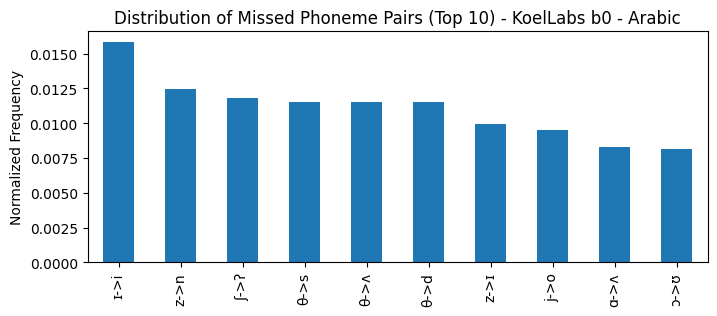

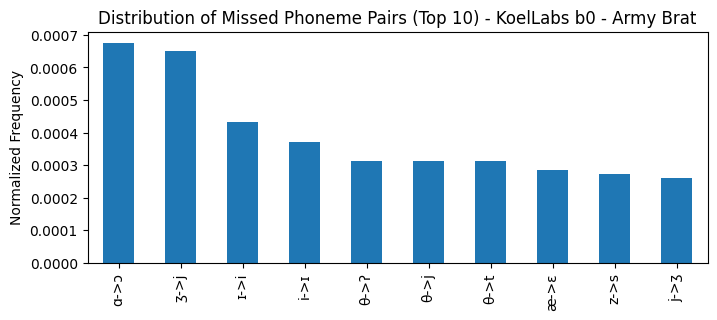

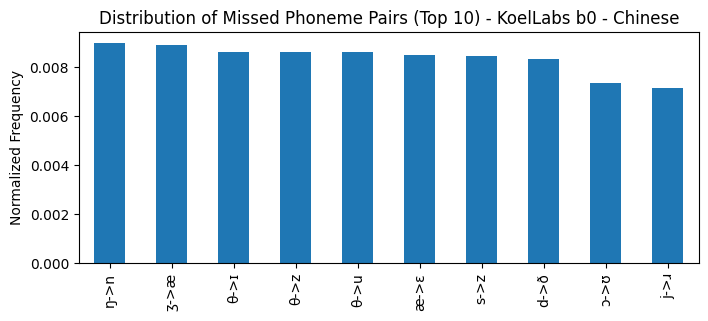

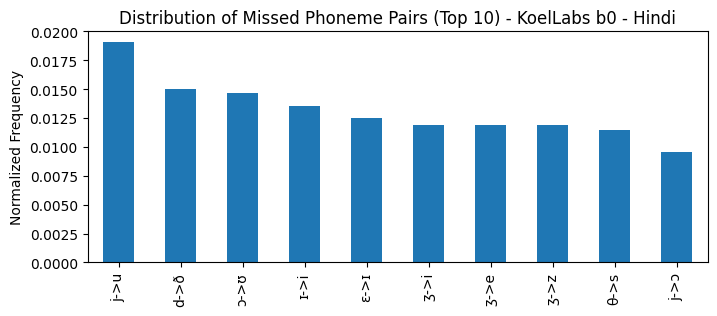

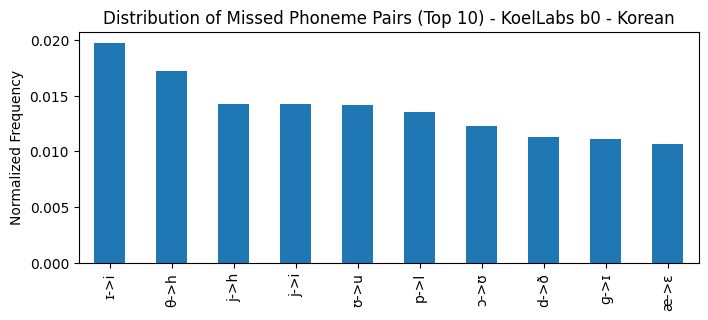

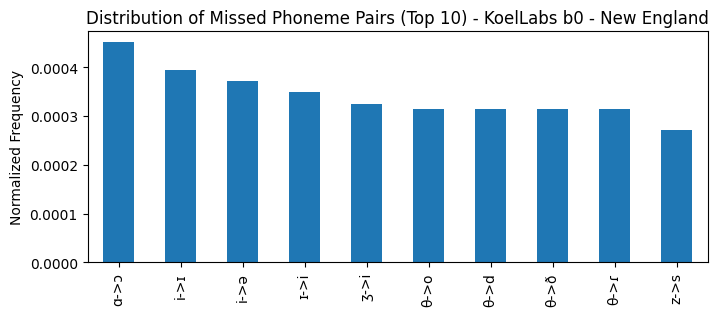

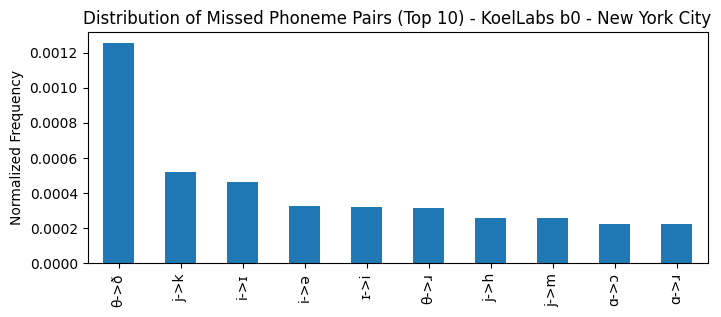

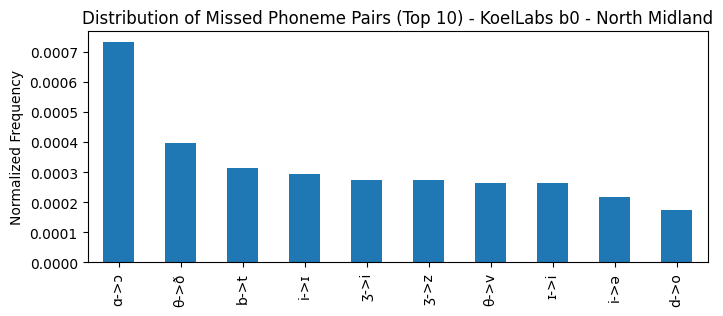

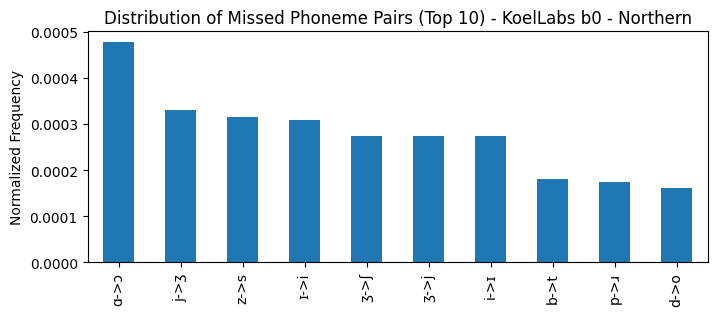

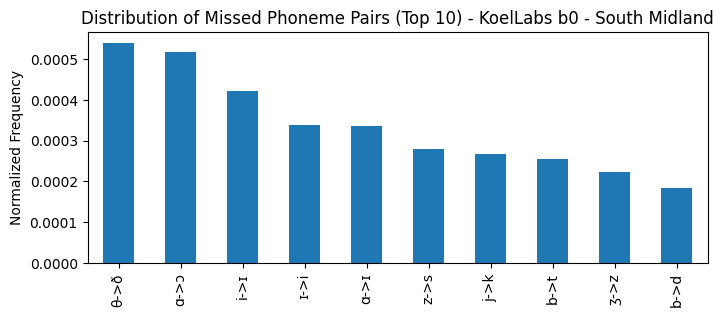

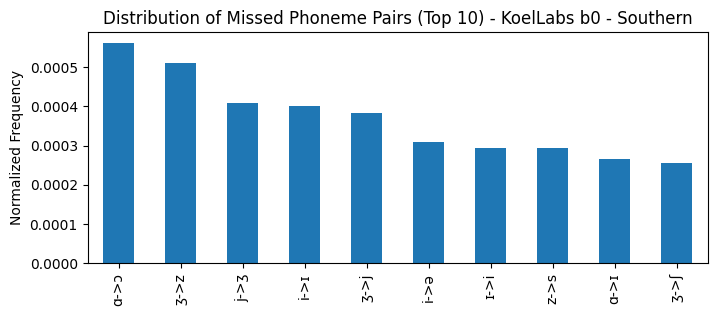

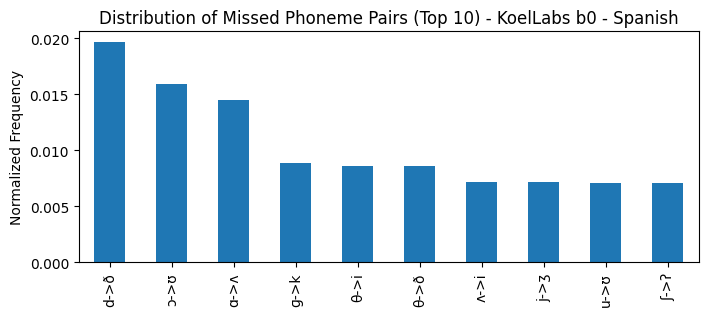

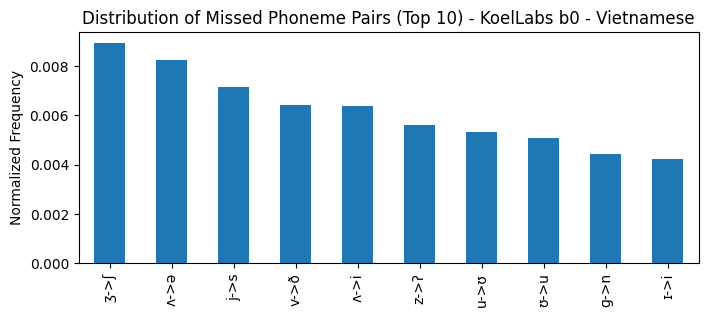

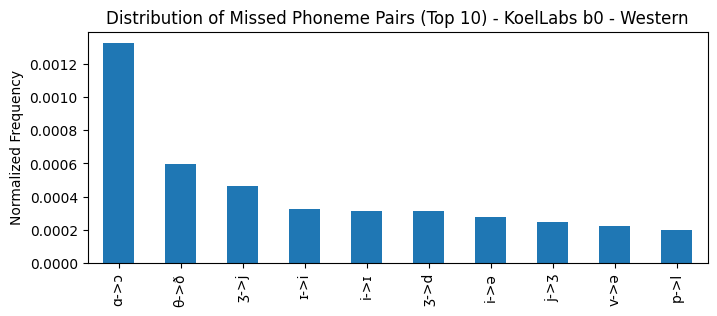

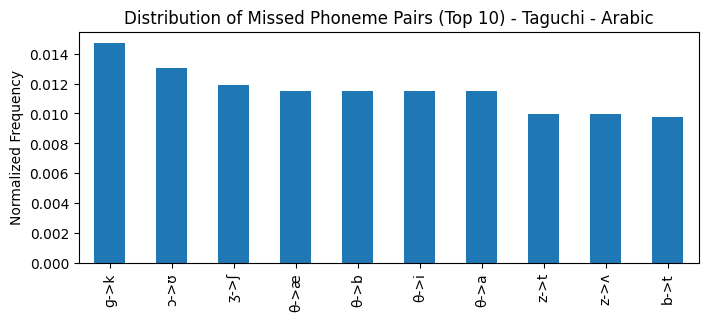

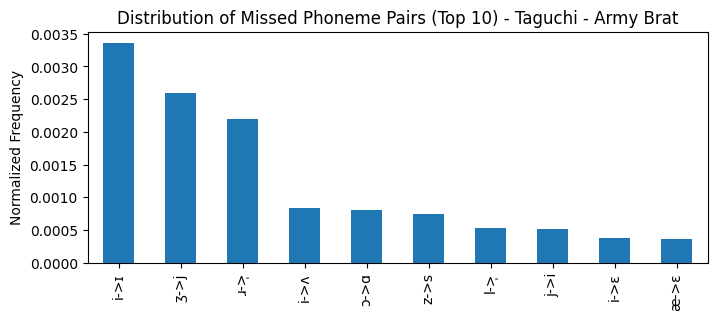

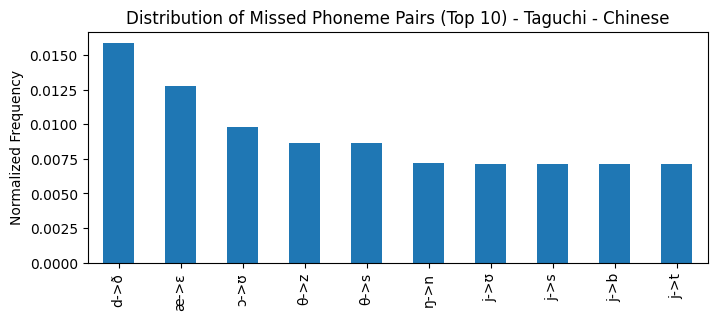

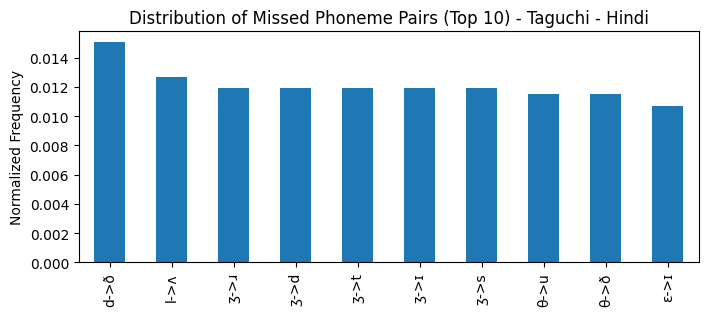

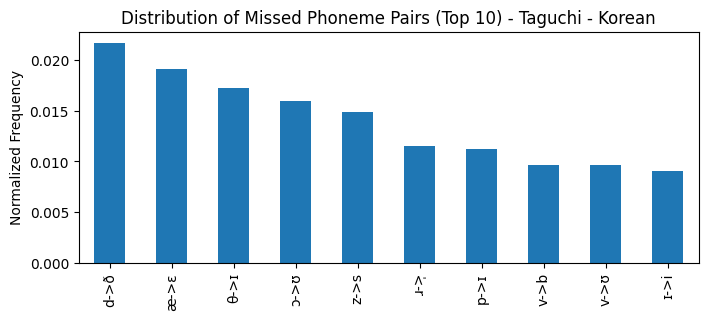

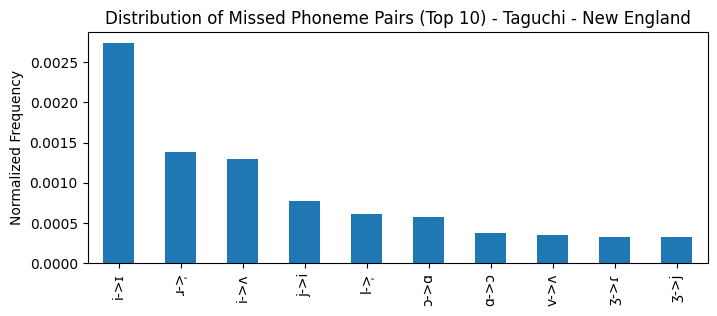

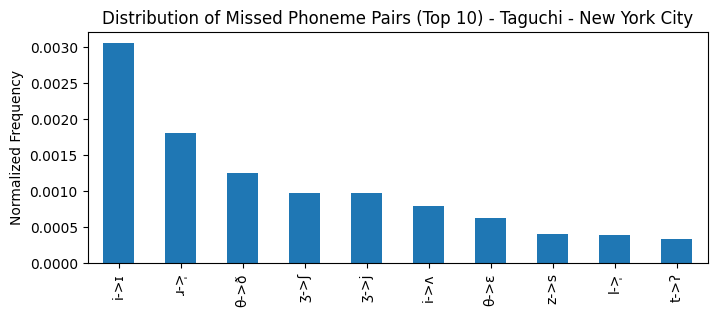

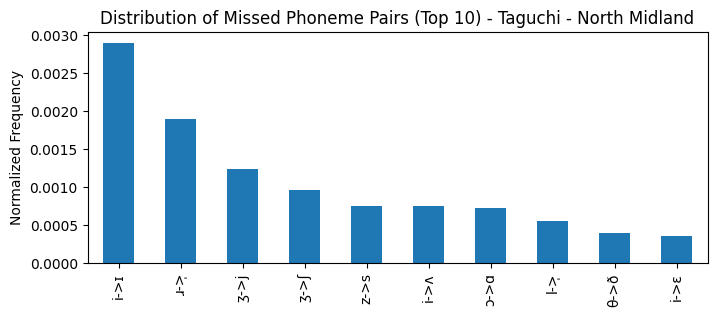

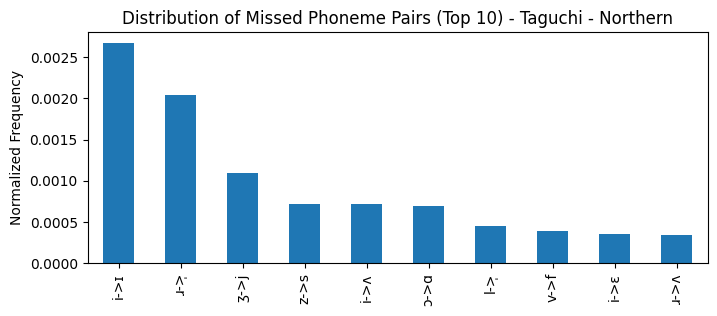

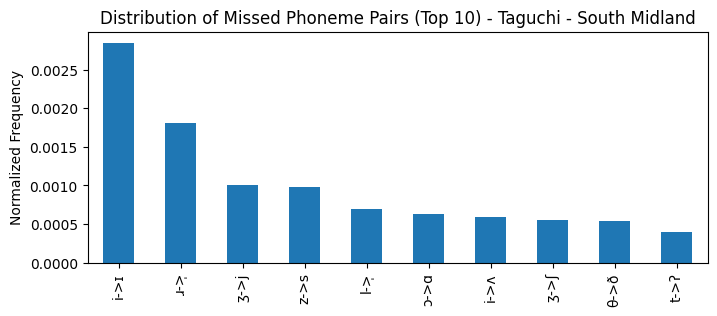

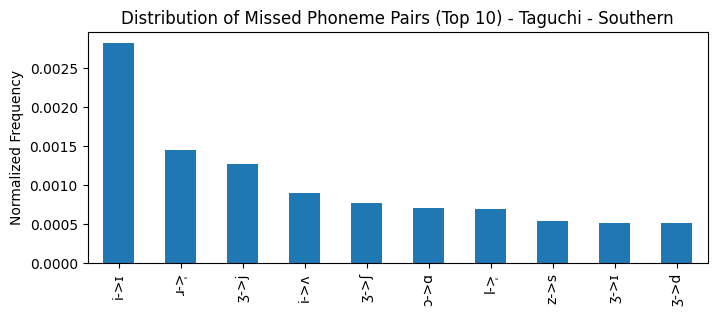

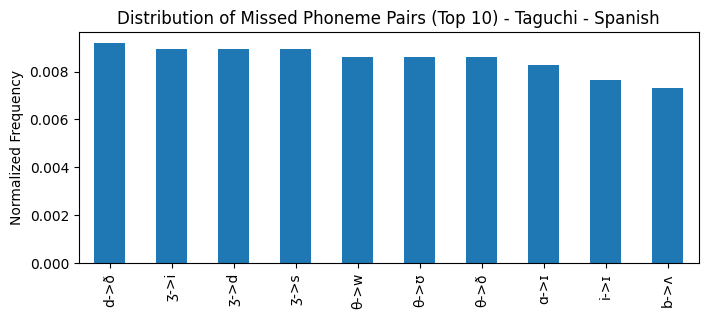

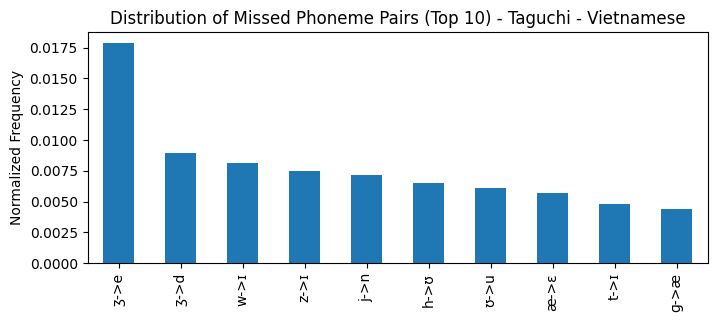

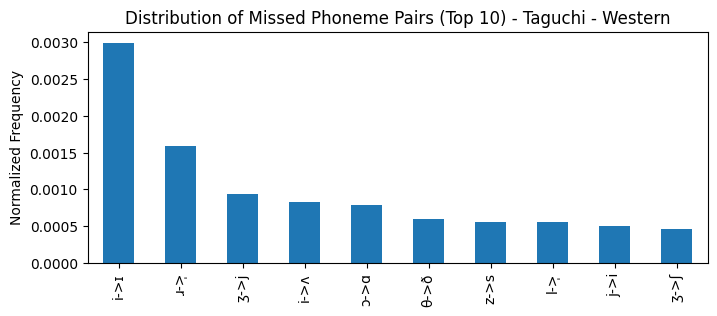

In [179]:
# plot the distribution of phoneme pairs as a bar chart stratified by background and model
for (model, background), model_background_scores in scores_norm.groupby(['Model', 'Background']):
    plt.figure(figsize=(8, 3))
    pair_counts = model_background_scores[phoneme_pairs].mean()
    pair_counts.sort_values(ascending=False, inplace=True)
    pair_counts.head(10).plot(kind='bar')
    plt.title('Distribution of Missed Phoneme Pairs (Top 10) - ' + str(model) + ' - ' + str(background))
    plt.ylabel('Normalized Frequency')
    plt.show()